## Goal  
in this notebook i have a number of simulated data from starbucks and i will try to predict weither a customer will complete an offer or not.  
P.S: complete means either they use the offer like a discount or buy 1 get 1, or by simply viewing it like an information offer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load data
portfolio= pd.read_csv('portfolio.csv')
profile= pd.read_csv('profile.csv')
transcript= pd.read_csv('transcript.csv')

## Cheacking for NaNs

In [3]:
portfolio.isnull().sum()

Unnamed: 0    0
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [4]:
profile.isnull().sum()

Unnamed: 0             0
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [5]:
transcript.isnull().sum()

Unnamed: 0    0
person        0
event         0
value         0
time          0
dtype: int64

## Dealing with NaNs

In [6]:
#in gender column group NaNs with other
profile['gender'].fillna("O", inplace=True)

In [7]:
#from document 118 == null. impute with the average for each group in gender
#find wich groups has null (118) in thier age
profile[profile['age']==118]['gender'].value_counts()

O    2175
Name: gender, dtype: int64

In [8]:
#find average age for 'other' group
average_age=np.round(profile.groupby('gender').mean().age.loc['O'])

In [9]:
#since all missing ages from the other group, use the average for the group
profile['age']= profile['age'].apply(lambda x : average_age if x == 118 else x)

In [10]:
#find wich groups has null in thier income
profile[profile['income'].isnull()].groupby('gender').count()['income']

gender
O    0
Name: income, dtype: int64

In [11]:
#average income for 'other'
average_income= np.round(profile.groupby('gender').mean().income.loc['O'])

In [12]:
#imput nan with average
profile['income']= profile['income'].apply(lambda x : average_income if np.isnan(x) else x)

In [13]:
#drop unnamed:0 column from all dataframes
profile.drop('Unnamed: 0', axis=1, inplace=True)
transcript.drop('Unnamed: 0', axis=1, inplace=True)
portfolio.drop('Unnamed: 0', axis=1, inplace=True)

## Data Analysis & Cleaning

C:\Users\Me\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='gender', ylabel='count'>

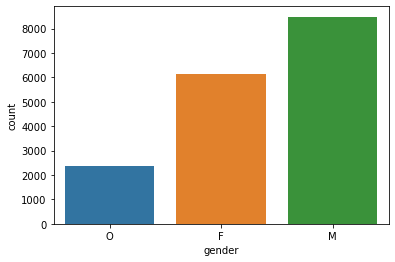

In [14]:
#analyse profile file first
#see gender count
sns.countplot(profile['gender'])

looks like males are more than female customers. lets see which one of them has more income

Text(0.5, 1.0, 'Income per gender')

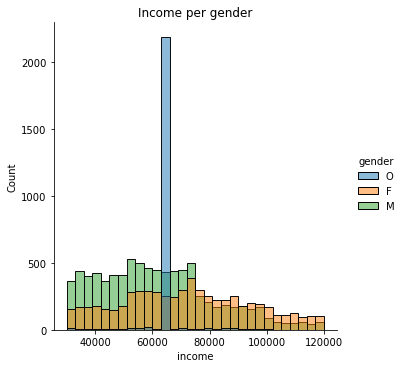

In [15]:
sns.displot(profile, x='income', hue='gender', bins=30)
plt.title('Income per gender')

remember that all the missing income were from the 'other' group, because I made every person with no gender as 'other'

Text(0, 0.5, 'income')

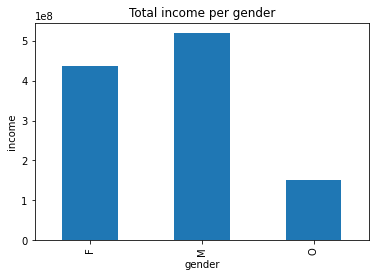

In [16]:
profile.groupby('gender').sum()['income'].plot(kind='bar')
plt.title('Total income per gender')
plt.ylabel('income')

males total income is higher even though the number of females in the higher income (78k and above) are higher than males.

In [17]:
#extract only the year from 'became_member_on' and create column 'year'
profile['year']= profile['became_member_on'].apply(lambda x : str( x )[:4])

Text(0.5, 1.0, 'loyalty program regestration per year')

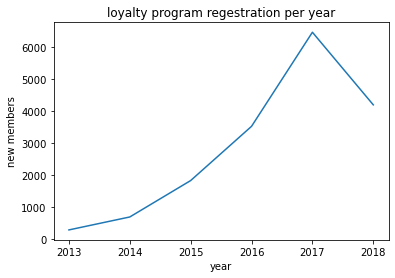

In [18]:
#see membership regstration throug the years
profile['year'].value_counts().sort_index().plot()
plt.xlabel('year')
plt.ylabel('new members')
plt.title('loyalty program regestration per year')

2017 was the highest year then it went down the next year.

In [19]:
#analys transcript file

#transcript['person'] == profile['id']
#change column name from person to id, to merge them
transcript.rename(columns={'person':'id'}, inplace=True)


In [20]:
#merge profile and transcript on 'id' column
df= profile.merge(transcript, on='id', how='outer')

In [21]:
#map the offer_id from df with id in portfolio

#create dict such that offers['offer_id']= offerName_difficulty_duration
offers=dict()
for offer, i, diff, dur in portfolio[['offer_type', 'id', 'difficulty', 'duration']].values:
    offers[i]= f'{offer}_{diff}_{dur}'


def value_col(col):
    """
    extract offer_id from value column and mapped it to the offer name
    
    input- value column
    
    output-  mapped offer names
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'offer id':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return offers[value]
    elif value_type == 'offer_id':
        value= col.split(':')[1].split(',')[0].replace("'", "").strip()
        return offers[value]
    else:
        return 'None'

In [22]:
#get offer names
df['offer']= df['value'].apply(value_col)

In [23]:
def value_col_id(col):
    """
    extract offer_id from value column
    
    input- value column
    
    output- offer_ids
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'offer id':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return value
    elif value_type == 'offer_id':
        value= col.split(':')[1].split(',')[0].replace("'", "").strip()
        return value
    else:
        return 'None'

In [24]:
#get offer ids
df['offer_id']= df['value'].apply(value_col_id)

In [25]:
def value_col_trans(col):
    """
    get transaction amount from value column
    
    input- value column
    
    output- transaction amount
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'amount':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return np.round(float(value), 2)
    else:
        return np.nan

In [26]:
#get transaction amount
df['amount']= df['value'].apply(value_col_trans)

Text(0.5, 1.0, 'total transactions per year')

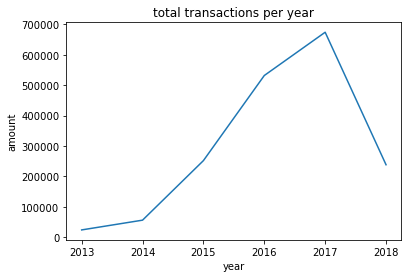

In [27]:
df.groupby('year').sum().amount.plot()
plt.ylabel("amount")
plt.title('total transactions per year')

both total transactions and # of regestration follow the same trend, climping up till 2017 then dropping.

Text(0.5, 1.0, 'total amount spent per gender')

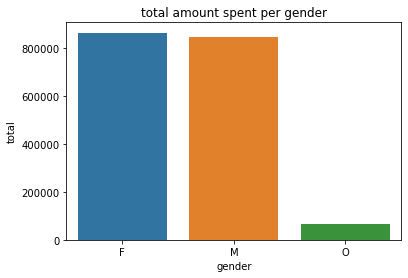

In [28]:
sns.barplot(x= ['F','M','O'], y=df.groupby('gender').sum().amount.values)
plt.xlabel('gender')
plt.ylabel('total')
plt.title('total amount spent per gender')

Text(0.5, 1.0, 'Total transactions per year per gender')

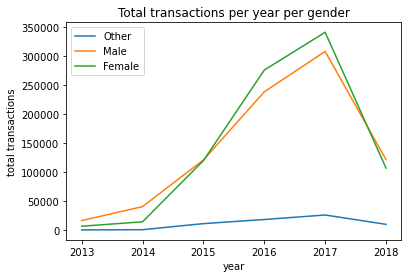

In [29]:
sns.lineplot(x=df.groupby(['gender','year']).sum().amount.loc['O'].index, y=df.groupby(['gender','year']).sum().amount.loc['O'].values , label='Other')
sns.lineplot(x=df.groupby(['gender','year']).sum().amount.loc['M'].index, y=df.groupby(['gender','year']).sum().amount.loc['M'].values , label='Male')
sns.lineplot(x=df.groupby(['gender','year']).sum().amount.loc['F'].index, y=df.groupby(['gender','year']).sum().amount.loc['F'].values , label='Female')
plt.ylabel('total transactions')
plt.title('Total transactions per year per gender')

around 2015 females started spending more at starbucks than males, then a sharp drop for 2018.

In [30]:
# get dummies for event column
df=pd.concat([df, pd.get_dummies(df['event'])], axis=1)

In [31]:
def infor(offer, viewed, complete):
    """
    if a informational offer is viewd then counted as completed
    
    input:
    offer column
    offer viewed column
    offer completed column
    
    output:
    0- not completed
    1- completed
    """
    if offer == 'informational_0_3' or offer == 'informational_0_4':
        if viewed == 1:
            return 1
    
    return complete

In [32]:
df['offer completed']=df.apply( lambda x : infor( x['offer'], x['offer viewed'], x['offer completed'] ) , axis=1)

In [33]:
#store tatal spending per person
total_amount=df.groupby('id').sum().amount

In [34]:
temp= df.sort_values('event')#sort values
new_df= temp[temp['offer completed']== 1]# extract completed offers to new_df
temp= temp[temp['offer completed'] != 1]# delete completed offers from temp
temp= temp[temp.event != 'transaction']# delete transactions from temp
temp.drop_duplicates(subset=['id', 'offer_id'], inplace=True)# drop duplicated rows
new_df= pd.concat([new_df, temp], ignore_index=True) # concat temp and new_df
new_df= pd.concat([new_df, pd.get_dummies(new_df['offer'], drop_first=True)], axis=1) #concat new_df and dummyies for offer

In [35]:
#map total transaction amount with person id
new_df['total_transaction']= new_df['id'].apply(lambda x : total_amount.loc[x])

In [36]:
#drop uneeded columns
new_df.drop(['became_member_on', 'event', 'time', 'amount', 'offer_id', 'id', 'value', 'offer received', 'offer viewed', 'transaction', 'offer'], axis=1, inplace=True)

In [37]:
# make dummiys for gender and year and concat with new_df
new_df = pd.concat([new_df, pd.get_dummies(new_df['gender']), pd.get_dummies(new_df['year'], drop_first=True)], axis=1)

In [38]:
#drop year and gender
new_df.drop(['gender', 'year', 'O'], axis=1, inplace=True)

In [39]:
#rename target column to completed
new_df.rename(columns= {'offer completed': 'completed'}, inplace=True)

In [40]:
#get classes dist
new_df['completed'].value_counts()

0    63288
1    44410
Name: completed, dtype: int64

## ML Modeling

In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [42]:
#create train test data
x=new_df.drop('completed', axis=1)
y= new_df['completed']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [43]:
#normalaize data then use knn
pipeline= Pipeline([
    ('scaler', MinMaxScaler()),
    ('cls',  KNeighborsClassifier())
])


In [44]:
#adjust how many nighbors affect the selection
params={'cls__n_neighbors': [1, 5, 10, 15, 20, 25]}

cv= GridSearchCV(pipeline, params, verbose=3)

In [45]:
cv.fit(x_train, y_train)#train

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .............................cls__n_neighbors=1; total time=  20.3s
[CV 2/5] END .............................cls__n_neighbors=1; total time=  19.7s
[CV 3/5] END .............................cls__n_neighbors=1; total time=  19.2s
[CV 4/5] END .............................cls__n_neighbors=1; total time=  19.7s
[CV 5/5] END .............................cls__n_neighbors=1; total time=  19.3s
[CV 1/5] END .............................cls__n_neighbors=5; total time=  33.5s
[CV 2/5] END .............................cls__n_neighbors=5; total time=  33.4s
[CV 3/5] END .............................cls__n_neighbors=5; total time=  32.9s
[CV 4/5] END .............................cls__n_neighbors=5; total time=  33.3s
[CV 5/5] END .............................cls__n_neighbors=5; total time=  33.1s
[CV 1/5] END ............................cls__n_neighbors=10; total time=  33.7s
[CV 2/5] END ............................cls__n_n

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('cls', KNeighborsClassifier())]),
             param_grid={'cls__n_neighbors': [1, 5, 10, 15, 20, 25]},
             verbose=3)

In [46]:
pred = cv.predict(x_test)#predict

In [47]:
#evaluate
from sklearn.metrics import classification_report, confusion_matrix
print("classification report:")
print(classification_report(y_test, pred))
print("-------------------------------------")
print('confusion matrix:')
print(confusion_matrix(y_test, pred))

classification report:
              precision    recall  f1-score   support

           0       0.60      0.70      0.65     18946
           1       0.44      0.34      0.38     13364

    accuracy                           0.55     32310
   macro avg       0.52      0.52      0.52     32310
weighted avg       0.54      0.55      0.54     32310

-------------------------------------
confusion matrix:
[[13321  5625]
 [ 8864  4500]]


## Enhance Performance 

Since data is unbalanced lets try undersampling and see if there is an improvment.

In [48]:
new_df.completed.value_counts()#data unbalanced

0    63288
1    44410
Name: completed, dtype: int64

In [45]:
#use downsampling
from sklearn.utils import resample
df_majority = new_df[new_df.completed==0]
df_minority = new_df[new_df.completed==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.completed.value_counts()

0    44410
1    44410
Name: completed, dtype: int64

In [46]:
#crete train test data using balansed data
x=df_downsampled.drop('completed', axis=1)
y= df_downsampled['completed']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [47]:
cv.fit(x_train, y_train)#train

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .............................cls__n_neighbors=1; total time=  13.3s
[CV 2/5] END .............................cls__n_neighbors=1; total time=  13.3s
[CV 3/5] END .............................cls__n_neighbors=1; total time=  13.3s
[CV 4/5] END .............................cls__n_neighbors=1; total time=  13.5s
[CV 5/5] END .............................cls__n_neighbors=1; total time=  14.7s
[CV 1/5] END .............................cls__n_neighbors=5; total time=  22.9s
[CV 2/5] END .............................cls__n_neighbors=5; total time=  22.3s
[CV 3/5] END .............................cls__n_neighbors=5; total time=  24.0s
[CV 4/5] END .............................cls__n_neighbors=5; total time=  22.1s
[CV 5/5] END .............................cls__n_neighbors=5; total time=  21.7s
[CV 1/5] END ............................cls__n_neighbors=10; total time=  22.7s
[CV 2/5] END ............................cls__n_n

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('cls', KNeighborsClassifier())]),
             param_grid={'cls__n_neighbors': [1, 5, 10, 15, 20, 25]},
             verbose=3)

In [52]:
pred = cv.predict(x_test)

In [53]:
print("classification report:")
print(classification_report(y_test, pred))
print("-------------------------------------")
print('confusion matrix:')
print(confusion_matrix(y_test, pred))

classification report:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53     13355
           1       0.56      0.68      0.62     13291

    accuracy                           0.58     26646
   macro avg       0.58      0.58      0.57     26646
weighted avg       0.58      0.58      0.57     26646

-------------------------------------
confusion matrix:
[[6271 7084]
 [4228 9063]]


## Results
there is a huge boost in the f1-score for the 1 class, from 38% to 62% and a 3% increase in accuracy by just balancing the data. further feature engineering or choosing other classifairs could improve the performance.

## Conclusion
we reached the goal of predicting if a customer will responce to an offer or not, the solution leaves a lot to be desired but it does the job. i would loved to explore how users spending behavior changes after reading an offer, it is quite diffuclite to do at my current level.  
Also deep learning or better feature engineering could be used to achive better results.  

Thank you.

## save the model & data

In [48]:
import pickle
f= open('model.pkl', 'wb')
pickle.dump(cv, f)
f.close()

new_df.to_csv('df.csv')
df_downsampled.to_csv('downsampled.csv')